In [1]:
from src.model import VAE
from src.trainer import SimCLRTrainer
from src.model import interpolate_latent
import torch
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
import numpy as np

from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

%load_ext autoreload
%autoreload 2

In [2]:
from corruption_utils import corruptions

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [5]:
class CMNISTGenerator:
    def __init__(self, dataset: torchvision.datasets.MNIST, corruption_fns: None | dict) -> None:
        self.dataset = dataset
        self.corruption_fns = corruption_fns
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.corruption_fns is not None:
            cfn = np.random.choice(
                list(self.corruption_fns.keys()), p=list(self.corruption_fns.values())
            )
            img = cfn(img)
            return img, label
        else:
            return img, label

    @property
    def size(self):
        return len(self.dataset)
    
class CMNIST(Dataset):

    def __init__(self, generator, transform) -> None:
        super().__init__()
        self.generator = generator
        self.transform = transform
        self.N = generator.size
        self.dataset = [None] * self.N
        with tqdm(range(self.N), unit="item") as bar:
            bar.set_description("Generating dataset")
            for i in bar:
                self.dataset[i] = self.generator[i]

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx) -> tuple:
        img, label = self.dataset[idx]
        img = self.transform(img)
        return img, label
    
    def display(self, idx):
        img, _ = self.__getitem__(idx)
        display(transforms.ToPILImage()(img))

In [6]:
def display_util(idx1, idx2, z: torch.Tensor, model: VAE, z_dim):
    with torch.no_grad():
        z1, z2 = z[idx1], z[idx2]
        display(transforms.ToPILImage()(model.decode(z1.view(1, -1))[0]))
        display(transforms.ToPILImage()(model.decode(z2.view(1, -1))[0]))
        z_inter = interpolate_latent(latent1=z1[z_dim:], latent2=z2[z_dim:], num_steps=11, device=device)
        z_combined = torch.cat([z1[:z_dim][None, :].repeat(11, 1), z_inter], dim=1)
        x_inter = model.decode(z_combined)
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

        z_inter = interpolate_latent(latent1=z1[:z_dim], latent2=z2[:z_dim], num_steps=11, device=device)
        z_combined = torch.cat([z_inter, z1[z_dim:][None, :].repeat(11, 1)], dim=1)
        x_inter = model.decode(z_combined)
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()


In [7]:
generator = CMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.3,
        corruptions.stripe: 0.3,
        corruptions.zigzag: 0.3,
        corruptions.canny_edges: 0.1,
    },
)


In [8]:
dataset = CMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)


Generating dataset: 100%|██████████| 60000/60000 [00:10<00:00, 5776.07item/s]


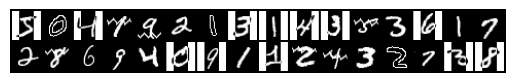

In [9]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
X, label = next(iter(dataloader))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()


In [365]:
Z_DIM = 16
TEMP = 0.1
BETA = 100

### cosine

In [366]:
vae = VAE(z_dim=Z_DIM).to(device)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-4)
trainer = SimCLRTrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": BETA},
    verbose_period=5,
    device=device,
)

In [367]:
trainer.fit(dataloader, 31)

Epoch 30: 100%|██████████| 469/469 [00:04<00:00, 109.72batch/s, c_loss=0.0141, vae_loss=16]   


In [368]:
vae.eval()
X_hat, latent_params, z = vae(X, explicit=True)


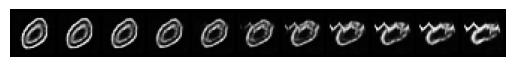

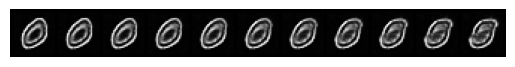

In [369]:
display_util(1, 11, z, vae, Z_DIM)


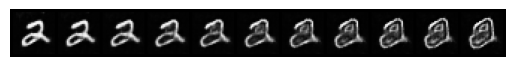

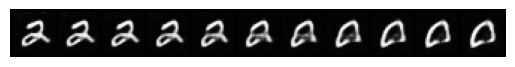

In [370]:
display_util(5, 1, z, vae, Z_DIM)

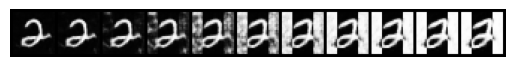

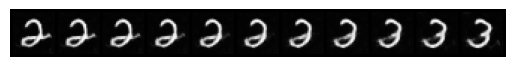

In [371]:
display_util(16, 7, z, vae, Z_DIM)

### cosine-var-adjust

In [372]:
vae = VAE(z_dim=Z_DIM).to(device)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = SimCLRTrainer(
    vae,
    optimizer,
    sim_fn="cosine-var-adjust",
    hyperparameter={"temperature": TEMP, "beta": BETA},
    verbose_period=5,
    device=device,
)

In [373]:
trainer.fit(dataloader, 31)

Epoch 30: 100%|██████████| 469/469 [00:04<00:00, 110.75batch/s, c_loss=0.000977, vae_loss=13.7]


In [374]:
vae.eval()
X_hat, latent_params, z = vae(X, explicit=True)

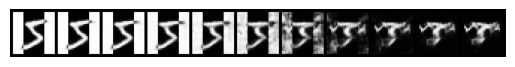

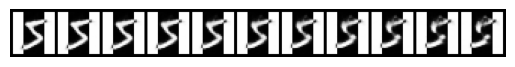

In [375]:
display_util(0, 11, z, vae, Z_DIM)


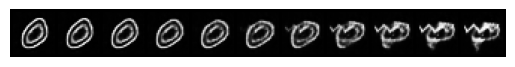

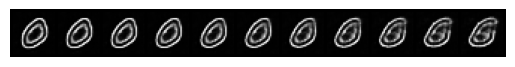

In [376]:
display_util(1, 11, z, vae, Z_DIM)


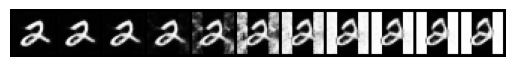

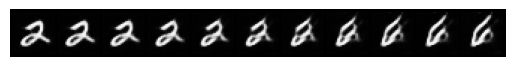

In [379]:
display_util(5, 13, z, vae, Z_DIM)

### arb

In [358]:
vae = VAE(z_dim=Z_DIM).to(device)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = SimCLRTrainer(
    vae,
    optimizer,
    sim_fn="bhattacharyya-coef",
    hyperparameter={"temperature": 0.1, "beta": 10},
    verbose_period=5,
    device=device,
)

In [359]:
torch.autograd.set_detect_anomaly(False)
trainer.fit(dataloader, 26)

Epoch 25: 100%|██████████| 469/469 [00:04<00:00, 109.67batch/s, c_loss=0.00568, vae_loss=15.9] 


In [360]:
vae.eval()
X_hat, latent_params, z = vae(X, explicit=True)

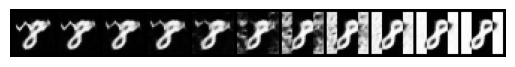

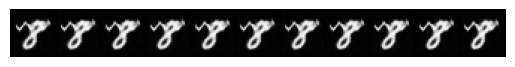

In [361]:
display_util(17, 31, z, vae, Z_DIM)

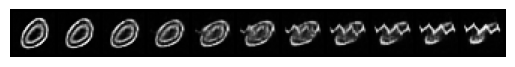

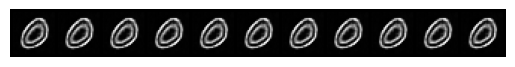

In [362]:
display_util(1, 11, z, vae, Z_DIM)


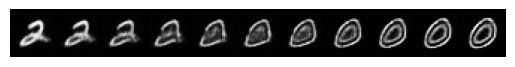

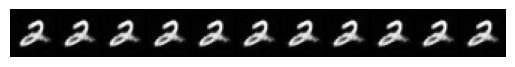

In [363]:
display_util(5, 1, z, vae, Z_DIM)
